# Trying to use hmmlearn library

In [1]:
from conversion_utils import *

def getCombinedStrokeSequencesFromDataFrames(paths, features):
    stroke_sequences = []
    for path in paths:
        strokes = getDataFrameFromPath(path)
        strokes = normalizeTimestamps(strokes)
        strokes = normalizeDataframeColumnsMinMax(strokes, ['x_position', 'y_position', 'timestamp'])
        #strokes = standardizeDataframeColumns(strokes, features)
        strokes = convertToNumpySequences(strokes, features)
        strokes = getSequencesWhereLengthBiggerThan(strokes, 1)

        stroke_sequences = stroke_sequences + strokes

    return stroke_sequences

def getCombinedStrokeSequencesFromDataFramesLengthOne(paths, features):
    stroke_sequences = []
    for path in paths:
        strokes = getDataFrameFromPath(path)
        strokes = normalizeDataframeColumnsMinMax(strokes, features)
        strokes = convertToNumpySequences(strokes, features)
        strokes = getSequencesWithLength(strokes, 1)

        stroke_sequences = stroke_sequences + strokes

    return stroke_sequences

def normalizeTimestamps(strokes):
    ids = strokes.abs_mt_tracking_id.unique()
    result = []
    for id in ids:
        index = strokes.loc[strokes['abs_mt_tracking_id'] == id].idxmin()[0]
        min_time = strokes.at[index, 'timestamp']
        s = strokes.loc[strokes['abs_mt_tracking_id'] == id]
        s['timestamp'] = s['timestamp'] - min_time
        result.append(s)

    return pd.concat(result)

# Gestures & Average Gesture Length of Datasets

In [2]:
users = ['data/test1/cua-db.db', 'data/test2/cua-db.db', 'data/test3/cua-db.db', 'data/test4/cua-db.db', 'data/test5/cua-db.db', 'data/train/cua-db.db']
average_len = 0
for user in users:
    X = getCombinedStrokeSequencesFromDataFrames([user], features = ['x_position', 'y_position'])
    average_len += len(X)
    gesture_length = 0
    # calculate avg. gesture lengtg
    for point in X:
        length = point.shape[0]
        gesture_length += length

    gesture_length = gesture_length / len(X)

    print(f'{user} - Gestures: {len(X)} Avg. Gesture Length: {gesture_length}')

print(f'Average len: {average_len / len(users)}')

data/sabrina/cua-db.db - Gestures: 195 Avg. Gesture Length: 90.22051282051282
data/alexander/cua-db.db - Gestures: 502 Avg. Gesture Length: 55.86852589641434
data/manuela/cua-db.db - Gestures: 315 Avg. Gesture Length: 92.5904761904762
data/nadine/cua-db.db - Gestures: 485 Avg. Gesture Length: 56.016494845360825
data/oehlboeck/cua-db.db - Gestures: 376 Avg. Gesture Length: 52.023936170212764
data/dominik1/cua-db.db - Gestures: 1791 Avg. Gesture Length: 72.1217197096594
Average len: 610.6666666666666


# Model Training

In [3]:
from hmmlearn import hmm
from conversion_utils import *
import numpy as np
import pandas as pd
import sqlite3

np.random.seed(42)

used_features = ['x_position', 'y_position', 'timestamp']
X = getCombinedStrokeSequencesFromDataFrames(['data/train/cua-db.db'], features =  used_features)
X_train, X_validate = generateTrainTestSplit(X, 0.85)

In [4]:
from sklearn.model_selection import RepeatedKFold 
from sklearn.model_selection import TimeSeriesSplit

def getHMMLeftToRightParameters(states):
    transmat = np.zeros((states, states))

    for i in range(states):
        if i == states - 1:
            transmat[i, i] = 1.0
        else:
            transmat[i, i] = transmat[i, i + 1] = 0.5

    # Always start in first state
    startprob = np.zeros(states)
    startprob[0] = 1.0

    return transmat, startprob

def trainModelWithDataKFold(model, X, n_splits):
    """
    Trains the passed model with the passed data
    with n_splits-fold cross validation and returns
    the average score of the model.
    """

    kf = TimeSeriesSplit(n_splits = n_splits) 
    scores = []

    for train_index, test_index in kf.split(X):
        train = [X[i] for i in train_index]
        test = [X[i] for i in test_index]

        model.fit(X = np.concatenate(train), lengths = getLengthsOfSequences(train))
        score = getScoreForModel(model, test)
        scores.append(score)
    return sum(scores) / len(scores)

def getScoreForModel(model, data):
    return sum(getIndividualScoresForModel(model, data))

def getIndividualScoresForModel(model, data):
    s = []
    for seq in data:
        s.append(model.score(X = seq) / len(seq))
    return s

In [13]:
import matplotlib
import matplotlib.pyplot as plt

print(f'Train set size: {len(X_train)} Validation set size: {len(X_validate)}')

min_states = 6
min_mixtures = 7
max_states = 7
max_mixtures = 8

best_score = float('-inf')
best_model = []
for states in range(min_states, max_states):
    for mixtures in range(min_mixtures, max_mixtures):
        print(f'Training model with {states} states and {mixtures} mixtures.', end = ' ')
        
        transmat, startprob = getHMMLeftToRightParameters(states)

        model = hmm.GMMHMM(
            n_components = states,
            n_mix = mixtures
        )

        #model.startprob_ = startprob
        #model.transmat_ = transmat
        
        score = trainModelWithDataKFold(model, X_train, 10)
        print(f'Score {score}')

        if score > best_score:
            best_score = score
            best_model = [states, mixtures, score]

states, mixtures, score = best_model

print(f'Best model has {states} states, {mixtures} mixtures with a score of {score}')

model = hmm.GMMHMM(
    n_components = states,
    n_mix = mixtures
)

transmat, startprob = getHMMLeftToRightParameters(states)

#model.startprob_ = startprob
#model.transmat_ = transmat

model.fit(X = np.concatenate(X_train), lengths = getLengthsOfSequences(X_train))

Train set size: 784 Validation set size: 139
Training model with 6 states and 7 mixtures.

ValueError: startprob_ must sum to 1.0 (got nan)

# Model Evaluation

In [5]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_roc_curve_multiple(fpr, tpr, roc_auc, group_size):
    if (len(fpr) != len(tpr) or len(tpr) != len(roc_auc)):
        return "Wrong input lengths"
    
    plt.title('Receiver Operating Characteristic')
    for i in range(0, len(fpr)):
        plt.plot(fpr[i], tpr[i], label = 'N = %d | AUC = %0.2f' % (group_size[i], roc_auc[i]))

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_eer(fpr, tpr, thresholds):
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_index = np.where(thresholds == eer_threshold)

    EER = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    plt.plot(fpr, label='FPR')
    plt.plot(fnr, label='FNR')
    plt.plot(eer_index, fpr[eer_index], 'ro', label="EER {:.2f}".format(EER*100))
    plt.xlabel('Thresholds')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.show()
    print(f'Equal Error Rate: {EER}')

def calculate_single_eer(fpr, tpr, thresholds):
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_index = np.where(thresholds == eer_threshold)

    EER = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return EER

def calculate_multiple_eer(fpr, tpr, thresholds, group_size):
    if (len(fpr) != len(tpr) or len(tpr) != len(thresholds)):
        return "Wrong input lengths"

    EER_list = []

    for i in range(0, len(fpr)):
        fnr = 1 - tpr[i]
        eer_threshold = thresholds[i][np.nanargmin(np.absolute((fnr - fpr[i])))]
        eer_index = np.where(thresholds[i] == eer_threshold)
        eer = fpr[i][np.nanargmin(np.absolute(fnr - fpr[i]))]
        EER_list.append((group_size[i], eer))

    return EER_list



In [6]:


test_datasets = ['data/test1/cua-db.db', 'data/test2/cua-db.db', 'data/test3/cua-db.db', 'data/test4/cua-db.db', 'data/test5/cua-db.db']
Y = []
for dataset in test_datasets:
    print(dataset)
    sequences = getCombinedStrokeSequencesFromDataFrames([dataset], features =  used_features)
    Y.append(sequences)

score_positive = getIndividualScoresForModel(model, X_validate)
print(f'Score positive: {sum(score_positive) / len(score_positive)}')
scores_negative = []
for data in Y:
    s = getIndividualScoresForModel(model, data)
    scores_negative.append(s)
    print(f'Score negative: {sum(s) / len(s)}')

#plt.figure(figsize=(40,20))
#for score in scores_negative:
#    plt.plot(score, color = 'red')
#
#plt.plot(score_positive, color = 'green')
#plt.show()

data/sabrina/cua-db.db
data/manuela/cua-db.db
data/alexander/cua-db.db
data/nadine/cua-db.db
data/oehlboeck/cua-db.db


NameError: name 'model' is not defined

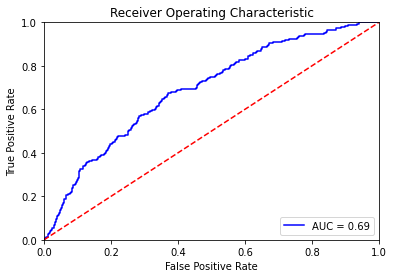

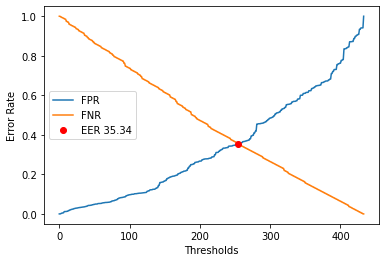

Equal Error Rate: 0.35344367325146825


In [11]:
# ROC For Single Gesture Prediciton
from sklearn import metrics
import matplotlib.pyplot as plt

score_positive = getIndividualScoresForModel(model, X_validate)
scores = score_positive

for test_set in Y:
    score_neg = getIndividualScoresForModel(model, test_set)
    scores = np.concatenate([scores, score_neg])

y_pos = np.ones(len(X_validate))
y_neg = np.zeros(len(scores) - len(X_validate))
y = np.concatenate([y_pos, y_neg])

fpr, tpr, thresholds = metrics.roc_curve(y, scores)
roc_auc = metrics.auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)
plot_eer(fpr, tpr, thresholds)

Scores: 2130
Scores: 2124
Scores: 2112
Scores: 2082
Scores: 2052
Scores: 1992


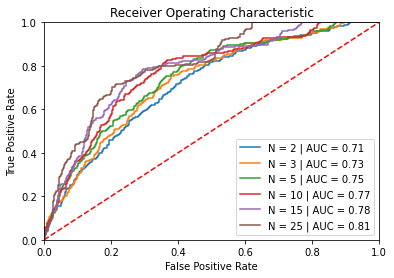

[(2, 0.3521202361782072), (3, 0.3293864370290635), (5, 0.3262987012987013), (10, 0.28579264947888094), (15, 0.26696329254727474), (25, 0.2620137299771167)]


In [12]:
# ROC for multiple gesture prediction
from sklearn import metrics
import matplotlib.pyplot as plt

#group_size = 2

def getPerformanceForGroupSize(group_size):
    score_positive = getIndividualScoresForModel(model, X_validate)
    score_positive_grouped = []

    for i in range(len(score_positive) - group_size):
        sub_list = score_positive[i:i + group_size]
        score_positive_grouped.append(sum(sub_list) / group_size)

    score_negative_grouped = []

    for test_set in Y:
        score_neg = getIndividualScoresForModel(model, test_set)

        for i in range(len(score_neg) - group_size):
            sub_list = score_neg[i:i + group_size]
            score_negative_grouped.append(sum(sub_list) / group_size)

    scores = np.concatenate([score_positive_grouped, score_negative_grouped])

    print(f'Scores: {len(scores)}')

    y_pos = np.ones(len(score_positive_grouped))
    y_neg = np.zeros(len(score_negative_grouped))
    y = np.concatenate([y_pos, y_neg])

    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    roc_auc = metrics.auc(fpr, tpr)

    return fpr, tpr, thresholds, roc_auc


fpr2, tpr2, thresholds2, roc_auc2 = getPerformanceForGroupSize(2)
fpr3, tpr3, thresholds3, roc_auc3 = getPerformanceForGroupSize(3)
fpr5, tpr5, thresholds5, roc_auc5 = getPerformanceForGroupSize(5)
fpr10, tpr10, thresholds10, roc_auc10 = getPerformanceForGroupSize(10)
fpr15, tpr15, thresholds15, roc_auc15 = getPerformanceForGroupSize(15)
fpr25, tpr25, thresholds25, roc_auc25 = getPerformanceForGroupSize(25)

fpr = [fpr2, fpr3, fpr5, fpr10, fpr15, fpr25]
tpr = [tpr2, tpr3, tpr5, tpr10, tpr15, tpr25]
roc_auc = [roc_auc2, roc_auc3, roc_auc5, roc_auc10, roc_auc15, roc_auc25]
thresholds = [thresholds2, thresholds3, thresholds5, thresholds10, thresholds15, thresholds25]
group_size = [2, 3, 5, 10, 15, 25]

plot_roc_curve_multiple(fpr, tpr, roc_auc, group_size)
eer = calculate_multiple_eer(fpr, tpr, thresholds, group_size)
print(eer)
#plot_roc_curve(fpr, tpr, roc_auc)
#plot_eer(fpr, tpr, thresholds)

# Training based on results of AUC and EER

In [8]:
from sklearn import metrics

max_states = 8
max_mixtures = 8

del(model)

for states in range(2, max_states):
    for mixtures in range(2, max_mixtures):
        try:
            model = hmm.GMMHMM(
                n_components = states,
                n_mix = mixtures
            )
            transmat, startprob = getHMMLeftToRightParameters(states)
            #model.startprob_ = startprob
            #model.transmat_ = transmat
            model.fit(X = np.concatenate(X_train), lengths = getLengthsOfSequences(X_train))

            score_positive = getIndividualScoresForModel(model, X_validate)
            scores = score_positive

            for test_set in Y:
                score_neg = getIndividualScoresForModel(model, test_set)
                scores = np.concatenate([scores, score_neg])

            y_pos = np.ones(len(X_validate))
            y_neg = np.zeros(len(scores) - len(X_validate))
            y = np.concatenate([y_pos, y_neg])

            fpr, tpr, thresholds = metrics.roc_curve(y, scores)
            roc_auc = metrics.auc(fpr, tpr)
            eer = calculate_single_eer(fpr, tpr, thresholds)

            print(f'States {states} | Mixtures {mixtures} | AUC {roc_auc} | EER {eer}')
        except:
            print(f'States {states} | Mixtures {mixtures} | threw Exception.')


States 2 | Mixtures 2 | AUC 0.6820876593025126 | EER 0.3694607581420182
States 2 | Mixtures 3 | AUC 0.6764251136776378 | EER 0.36412172984516816
States 2 | Mixtures 4 | AUC 0.6787929429557575 | EER 0.35184196476241325
States 2 | Mixtures 5 | AUC 0.6816946750635623 | EER 0.3555792845702082
States 2 | Mixtures 6 | AUC 0.6840902911060522 | EER 0.3609183128670582
States 2 | Mixtures 7 | AUC 0.6847095389977315 | EER 0.3561131873998932
States 3 | Mixtures 2 | AUC 0.6902430746451729 | EER 0.35344367325146825
States 3 | Mixtures 3 | AUC 0.6868808761563759 | EER 0.3566470902295782
States 3 | Mixtures 4 | AUC 0.6859004003278838 | EER 0.3561131873998932
States 3 | Mixtures 5 | AUC 0.6889549596397246 | EER 0.3587827015483182
States 3 | Mixtures 6 | AUC 0.686384683935479 | EER 0.3587827015483182
States 3 | Mixtures 7 | AUC 0.6883793766634845 | EER 0.3598505072076882
States 4 | Mixtures 2 | AUC 0.6922417369109454 | EER 0.37479978643886813
States 4 | Mixtures 3 | AUC 0.6720844241292323 | EER 0.405232

In [9]:
 states = 3
 mixtures = 2
 model = hmm.GMMHMM(
    n_components = states,
    n_mix = mixtures
)
transmat, startprob = getHMMLeftToRightParameters(states)
model.startprob_ = startprob
model.transmat_ = transmat
model.fit(X = np.concatenate(X_train), lengths = getLengthsOfSequences(X_train))

GMMHMM(algorithm='viterbi', covariance_type='diag',
       covars_prior=array([[[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5]]]),
       covars_weight=array([[[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]]]),
       init_params='stmcw',
       means_prior=array([[[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]]]),
       means_weight=array([[0., 0.],
       [0., 0.],
       [0., 0.]]),
       min_covar=0.001, n_components=3, n_iter=10, n_mix=2, params='stmcw',
       random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
       verbose=False,
       weights_prior=array([[1., 1.],
       [1., 1.],
       [1., 1.]]))